# Dataset Visualization & Feature Extraction

After some sanitization of inputs (discarding ineligible replays) and standardizing the formatting of replay filenames, we have a shortlist of **1979** unique games to explore with. Based on initial results, the same procedure can be run on a larger set of non-pro player replays in a wider range of ranked leagues.

In [1]:
import os
import sys
import spawningtool.parser
from collections import defaultdict

In [2]:
# Where replays are located
replay_dir = "replays"
# Where we should copy over the sanitized replays
output_dir = "sanitized_replays"

In [3]:
matchup_dict = defaultdict(list)
race_dict = defaultdict(list)

for (dirpath, dirnames, filenames) in os.walk(replay_dir):
    for filename in filenames:
        try:
            matchup, _, _ = filename.split('_')
            # Build up classification by matchup
            matchup_dict['v'.join(sorted(matchup.split('v')))].append(filename)
            # Build up classification by race
            one, two = matchup.split('v')
            race_dict[one].append((filename, 1))
            race_dict[two].append((filename, 2))
        except Exception as e:
            print(e)
            print(filename)
    break

## Dataset-level population metrics

Below are some metrics on the population of replays we are classifying on. There is a bias towards the Protoss race, likely due to the relative proportion of active professional players utilizing this race in the recent time period. As seen below, games that involve Protoss players occupy roughly 75% of this dataset while games involving the other two races are around 60%. This should not affect our classification results since we will be classifying within each race, we may simply have less confidence on the non-Protoss results.

In [4]:
for key in matchup_dict.keys():
    print(f"Matchup {key}: {len(matchup_dict[key])}")

for key in race_dict.keys():
    print(f"Race {key}: {len(race_dict[key])}")

Matchup PvP: 303
Matchup PvT: 459
Matchup PvZ: 484
Matchup TvT: 144
Matchup TvZ: 388
Matchup ZvZ: 201
Race P: 1549
Race T: 1135
Race Z: 1274


## Dissecting a game

Many things are happening simultaneously in a game of Starcraft. Broadly speaking, players balance between 3 goals: Economy, Offense, and Defence. More specifically, there are 3 resources in the game players need to balance, Minerals, Vespene Gas, and Supply. Minerals and Gas are used to produce both Buildings, Upgrades, and Units. A set amount of Supply is consumed by each unit on the playing field currently.

There are a few classes of buildings and units which we will breakdown as follows (P/T/Z):
- Economy
    - Nexus/Command Center/Hatchery: Main collection point for resources and (only) initial building given to players
- Supply
    - Pylon/Supply Depot/\[Overlord\]: Structures which increase available Supply (capped at 200). Note that for Zerg, this is a unit instead.
- Production (basic)
    - Gateway,Stargate,Robotics Facility/Barracks,Factory,Starport/\[Larvae\]: Basic offensive unit production building. Note that for Zerg, ALL other units are produced from the basic *Larvae* unit which is spawned at a constant rate from Hatcheries.
- Tech (basic)
    - Cybernetics Core,Twilight Council/Ghost Academy,Techlab add-on/Spawning Pool,Baneling Nest,Roach Warren,Lair
- Tech (advanced)
    - Templar Archives,Dark Shrine,Fleet Beacon,Robotics Bay/Fusion Core/Hydralist Den,Lurker Den,Spire,Hive,Ultralisk Cavern,Greater Spire
- Upgrades
    - Forge/Armory,Engineering Bay/Evolution Chamber
    
This is just a personal categorical breakdown of the classes of structures and their roles in the game. Each building also has dependencies to be fulfilled before they can be built. Furthermore, for some cases, structures fulfils both a Tech role as well as an Upgrade role (one unlocks both new units to create as well as new upgrades to research). One can access the full structure tree for each race at:
- [Protoss](https://liquipedia.net/starcraft2/Protoss_Tech_Tree_(Legacy_of_the_Void))
- [Terran](https://liquipedia.net/starcraft2/Terran_Tech_Tree_(Legacy_of_the_Void))
- [Zerg](https://liquipedia.net/starcraft2/Zerg_Tech_Tree_(Legacy_of_the_Void))

The purpose of creating buildings outside the Production class is to unlock a greater variety of units that one can create. With units that require more investment supposedly generating more efficiency (in terms of resources utilized against potential damage caused to the opponent).

## Visualizing a game

For this exercise, we will dig into a particular replay (`PvT_1614448222_7313968-7314011.SC2Replay`) to visualize the features we will be extracting for classification.

We will attempt to visualize a recent game in the 2020 world championships between two pro players PartinG (P) and TY (T).

In [5]:
def fingerprint(game):
    players = game['players']
    matchup = f"{players[1]['race'][0]}v{players[2]['race'][0]}"
    timestamp = game['unix_timestamp']
    uidPair = f"{players[1]['uid']}-{players[2]['uid']}"
    print(f"PlayerOne: {players[1]['name']}")
    print(f"PlayerTwo: {players[2]['name']}")
    return "_".join([matchup, str(timestamp), uidPair])

sample_replay = "PvT_1614448222_7313968-7314011.SC2Replay"
sample_game = spawningtool.parser.parse_replay(sample_replay)
print("Game unique fingerprint:", fingerprint(sample_game))

PlayerOne: PartinG
PlayerTwo: TYTY
Game unique fingerprint: PvT_1614448222_7313968-7314011


In [6]:
print(sample_game.keys())

dict_keys(['buildOrderExtracted', 'message', 'build', 'baseBuild', 'category', 'expansion', 'unix_timestamp', 'frames', 'game_type', 'region', 'map', 'map_hash', 'cooperative', 'players', 'include_map_details', 'frames_per_second'])


In [7]:
print(sample_game['frames'], sample_game['frames_per_second'])

13620 22.4


In [8]:
print(sample_game['players'][1].keys())

dict_keys(['name', 'pick_race', 'race', 'league', 'level', 'is_winner', 'result', 'is_human', 'handicap', 'color', 'uid', 'region', 'supply', 'team', 'clock_position', 'commander', 'abilities', 'buildOrder', 'unitsLost'])


In [9]:
#sample_game['players'][1]['buildOrder'][:10]

In [10]:
#sample_game['players'][1]['abilities']

### Visual overview of first 5min from perspective of each player

We plot the structures and units produced by each player along a compressed time axis, noting gaps longer than 3s.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from lotv_constants import (
    VESPENE_UNITS, SUPPLY_UNITS, WORKER_UNITS, BASE_UNITS,
    GROUND_UNITS, AIR_UNITS, TECH_UNITS, STATIC_UNITS,
    ARMY_UNITS, ARMY_AIR, ARMY_GROUND,
    STRUCTURES, UNITS, UPGRADES
)
from icon_mapping import ICON_MAP
ICON_DIR = 'icons'

# Memoized plt imgs
mem_icons = dict()

In [12]:
BUILD_ORDER_TIME_CUTOFF = 300 # seconds
FILLER_TIME_THRESHOLD = 3
FILLER_DUMMY_NAME = 'FILLER'

In [13]:
def build_visual_sequence(raw_buildOrder, cutoff=BUILD_ORDER_TIME_CUTOFF):
    visual_buildOrder = []
    for event in raw_buildOrder:
        # Convert time to seconds
        t_min, t_sec = list(map(int, event['time'].split(':')))
        t_event = t_min*60+t_sec
        # Break after 5min
        if (t_event >= cutoff):
            break
        cur_event = dict(event)
        cur_event['time'] = t_event
        # Check if there is a gap longer than 1 second between this event and the last
        t_delta = cur_event['time'] - visual_buildOrder[-1]['time'] if len(visual_buildOrder) > 0 else 0
        if (t_delta > FILLER_TIME_THRESHOLD):
            # Insert dummy event(s) with time gap
            for i in range(t_delta//FILLER_TIME_THRESHOLD):
                visual_buildOrder.append({
                    'icon': None,
                    'time': t_delta,
                    'name': FILLER_DUMMY_NAME,
                })
        # Add mapping of visual icon
        event_name = event['name'].strip().replace(' ','') # Clean up name
        cur_event['name'] = event_name
        cur_event['icon'] = ICON_MAP[event_name]
        # Add event back into list
        visual_buildOrder.append(cur_event)
    return visual_buildOrder

In [14]:
def plot_game_series(data, save_file=None):
    fig, ax = plt.subplots(4, len(data), figsize=(len(data), 8), dpi=64)
    for i, event in enumerate(data):
        for j in range(4):
            ax[j][i].axis('off')
        if (event['icon'] is None):
            continue
        rank = 1
        if (event['name'] in STRUCTURES):
            rank = 1
        elif (event['name'] in UNITS):
            rank = 2
        elif (event['name'] in UPGRADES):
            rank = 3
        else:
            print(f"ERROR: {event['name']} not found!")
        ax[0][i].text(0.3,0,f"{event['time']//60}:{event['time']%60:02}")
        if (event['icon'] in mem_icons):
            ax[rank][i].imshow(mem_icons[event['icon']])
        else:
            img = mpimg.imread(os.path.join(ICON_DIR,event['icon']))
            mem_icons[event['icon']] = img
            ax[rank][i].imshow(img)
    plt.tight_layout()
    if (save_file is not None):
        fig.savefig(f"{save_file}.png")
    plt.show()

### Graphical Display (Actions)

*Images are attributed to Blizzard Entertainment Inc.* used here to demonstrate the variety of actions possible in this domain of determining Build Order.

We plot 3 layers of actions, in order (top-down): STRUCTURES, UNITS, UPGRADES. From this we observe that the UPGRADES field is quite sparse and there are many gaps between events during which no actions are taken.

In the next section, we will plot additional aggregate data regarding the 3 resources available: Supply, Minerals and Vespene Gas.

In [15]:
playerOne_buildOrder = sample_game['players'][1]['buildOrder']
playerOne_5_min_visual_mapping = build_visual_sequence(playerOne_buildOrder)
print(len(playerOne_5_min_visual_mapping))
#plot_game_series(playerOne_5_min_visual_mapping, save_file=f"PvT_1614448222_7313968-7314011_{1}")

134


In [16]:
playerTwo_buildOrder = sample_game['players'][2]['buildOrder']
playerTwo_5_min_visual_mapping = build_visual_sequence(playerTwo_buildOrder)
print(len(playerTwo_5_min_visual_mapping))
#plot_game_series(playerTwo_5_min_visual_mapping, save_file=f"PvT_1614448222_7313968-7314011_{2}")

138


In [17]:
# Extra - just to verify mapping is correct for Zerg
zerg_replay = "ZvP_1614353044_11982351-11981945.SC2Replay"
zvp_game = spawningtool.parser.parse_replay(zerg_replay)
print("Game unique fingerprint:", fingerprint(zvp_game))
zvp_playerOne, zvp_playerTwo = (zvp_game['players'][1]['buildOrder'],zvp_game['players'][2]['buildOrder'])
zvp_playerOneVisual, zvp_playerTwoVisual = (build_visual_sequence(zvp_playerOne), build_visual_sequence(zvp_playerTwo))
print(len(zvp_playerOneVisual), len(zvp_playerTwoVisual))

PlayerOne: Reynor
PlayerTwo: Stats
Game unique fingerprint: ZvP_1614353044_11982351-11981945
152 141


In [18]:
#plot_game_series(zvp_playerOneVisual, save_file=f"ZvP_1614353044_11982351-11981945_{1}")

In [19]:
#plot_game_series(zvp_playerTwoVisual, save_file=f"ZvP_1614353044_11982351-11981945_{2}")

### Plotting aggregate data (Resources)

Unfortunately, spawningtool does not make available the frame-by-frame information on resources available to each player. For this information, we will have to use [sc2reader](https://pypi.org/project/sc2reader/) for extraction.

The output of sc2reader is event-driven and not nicely formatted, I've referred to this [sample notebook](https://github.com/IBM/starcraft2-replay-analysis/blob/master/notebooks/starcraft2_replay_analysis.ipynb) for many of the extraction functions herein.

In [20]:
import sc2reader
import numpy as np
from matplotlib import ticker

In [43]:
from sc2replayParsers import SC2ReplayData, STATS_GROUPS
from zipUtil import zip_write, zip_read

In [22]:
# Differences between our two sets of constants
# with the exception of Creeptumor, NydusCanal for which the latter is depreciated, no difference
# *Creeptumor doesn't factor into BuildOrders
print(STRUCTURES.symmetric_difference(set(STATIC_UNITS)|set(VESPENE_UNITS)|set(BASE_UNITS)|set(GROUND_UNITS)|set(TECH_UNITS)|set(AIR_UNITS)))
# UNITS extra (extra state-specific names which may be safely ignored)
print(UNITS-(set(WORKER_UNITS)|set(ARMY_UNITS)))
# WORKER|ARMY extras (these are Zerg spawned units which BuildOrder does not consider)
print((set(WORKER_UNITS)|set(ARMY_UNITS))-UNITS)

{'NydusCanal', 'Pylon', 'SupplyDepot', 'Creeptumor'}
{'VikingAssault', 'LurkerMPEgg', 'RavagerCocoon', 'BattleHellion', 'VikingFighter'}
{'InfestorTerran', 'InfestedTerran', 'Changeling', 'Broodling'}


In [23]:
sc2replay_data = SC2ReplayData.parse_replay(replay_file=sample_replay)
data_dump = sc2replay_data.as_dict()
sc2replay_playerOne, sc2replay_playerTwo = data_dump['stats'][1], data_dump['stats'][2]

In [24]:
for p in sc2replay_data.replay.players:
    print(p.detail_data)

{'name': 'PartinG', 'bnet': {'region': 3, 'program_id': b'\x00\x00S2', 'subregion': 1, 'uid': 7313968}, 'race': 'Protoss', 'color': {'a': 255, 'r': 0, 'g': 66, 'b': 255}, 'control': 2, 'team': 1, 'handicap': 100, 'observe': 0, 'result': 1, 'working_set_slot': 1, 'hero': b''}
{'name': 'TYTY', 'bnet': {'region': 3, 'program_id': b'\x00\x00S2', 'subregion': 1, 'uid': 7314011}, 'race': 'Terran', 'color': {'a': 255, 'r': 180, 'g': 20, 'b': 30}, 'control': 2, 'team': 0, 'handicap': 100, 'observe': 0, 'result': 2, 'working_set_slot': 13, 'hero': b''}


In [30]:
data_dump['player_names']

['Player 1 - PartinG (Protoss)', 'Player 2 - TYTY (Terran)']

In [31]:
#data_dump['stats_names']

In [32]:
@ticker.FuncFormatter
def time_formatter(sec, pos):
    return f'{int(sec//60):02}:{int(sec%60):02}'

def plot_stat_player(playerData, key, fps=22.4, **kwargs):
    # Stats are recorded every 10s (each second has 'frames_per_second' frames)
    data = playerData[key][:int(BUILD_ORDER_TIME_CUTOFF*fps/160)]
    plot_stat_graph(data, name=key, fps=fps, **kwargs)
    
def plot_stat_graph(stat_data, name=None, fps=22.4, ax=None, show=True):
    if (ax is None):
        fig, ax = plt.subplots()
    data = np.asarray(stat_data)
    frame_to_seconds = np.vectorize(lambda x: int(x/fps))
    ax.xaxis.set_major_formatter(time_formatter)
    ax.plot(frame_to_seconds(data[:,0]), data[:,1], label=name)
    ax.legend()
    if (show):
        plt.show()

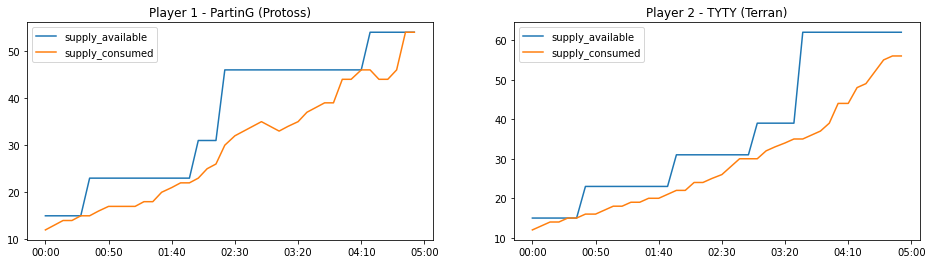

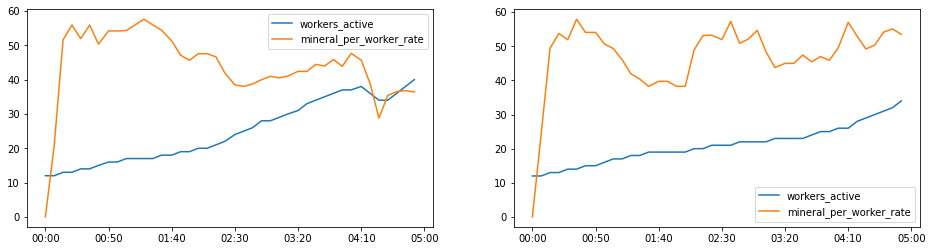

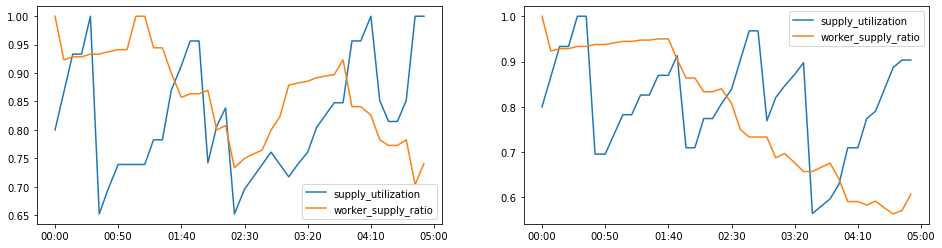

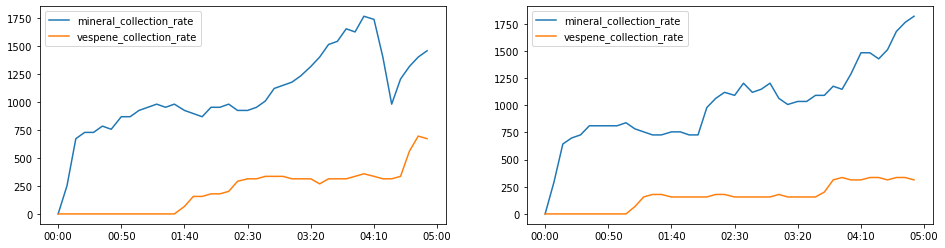

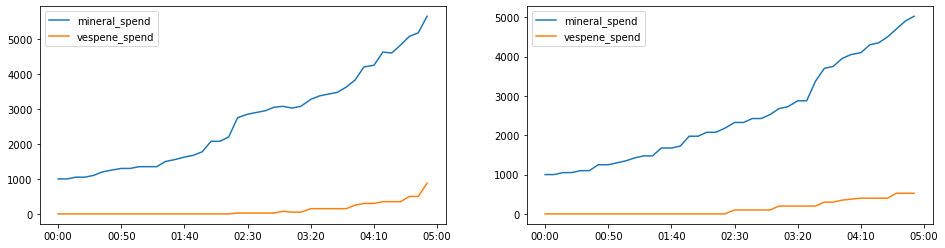

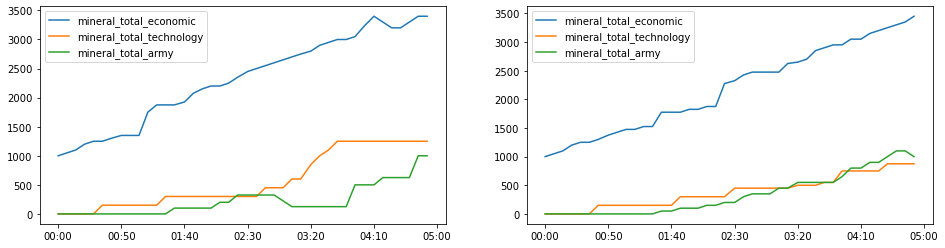

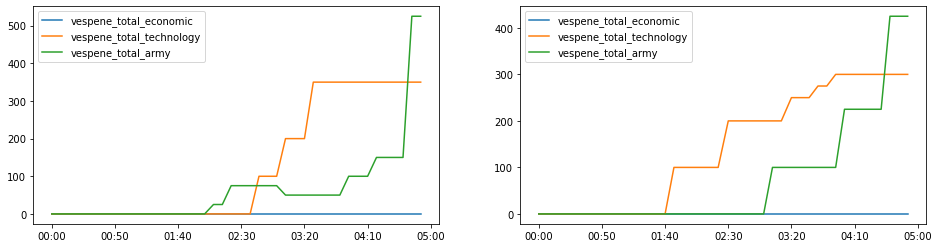

In [33]:
# Here, we grab important MACRO information that will be simultaneously useful alongside discrete actions in the BuildOrder
heading = False
for key_li in STATS_GROUPS:
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    if (not heading):
        for i in range(2):
            ax[i].set_title(data_dump['player_names'][i])
        heading = True
    for key in key_li:
        plot_stat_player(sc2replay_playerOne, key, fps=data_dump['frames_per_second'], ax=ax[0], show=False)
        plot_stat_player(sc2replay_playerTwo, key, fps=data_dump['frames_per_second'], ax=ax[1], show=False)
plt.show()

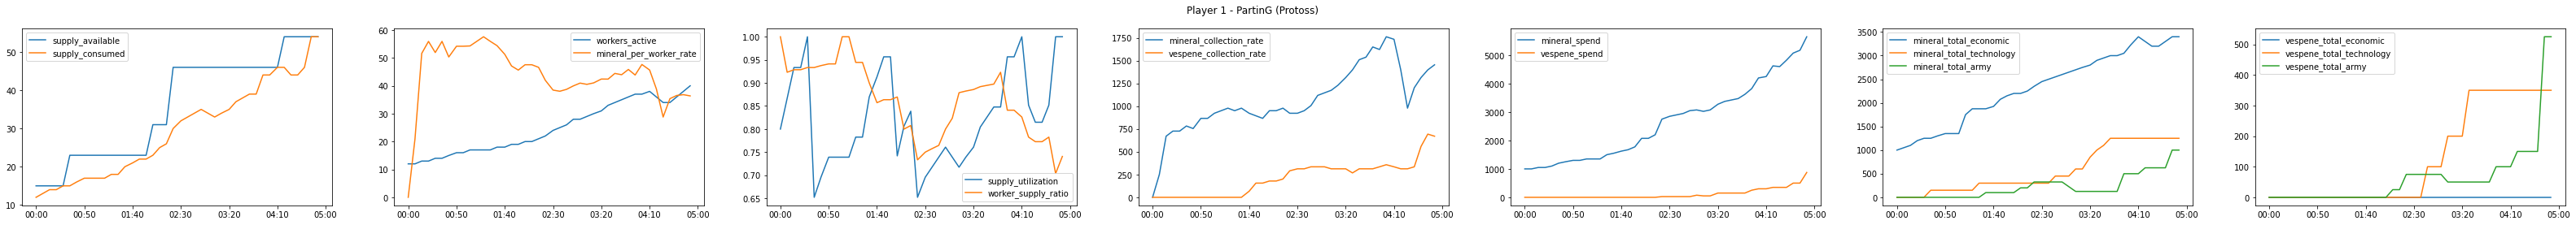

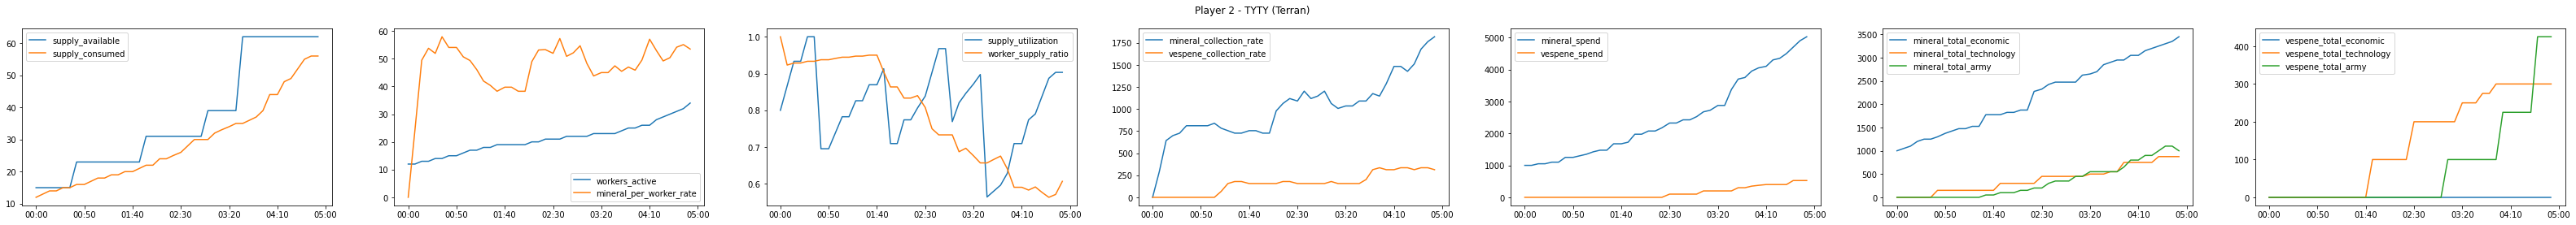

In [34]:
for i, player in ((0,sc2replay_playerOne), (1,sc2replay_playerTwo)):
    fig, ax = plt.subplots(1,len(STATS_GROUPS), figsize=(8*len(STATS_GROUPS),4))
    fig.suptitle(data_dump['player_names'][i])
    for j, key_li in enumerate(STATS_GROUPS):
        for key in key_li:
            plot_stat_player(player, key, ax=ax[j], show=False)
    fig.savefig(f"{data_dump['player_names'][i]}.png")
    plt.show()